# Lock-in Amplifier Simulation with Python

## Introduction
A lock-in amplifier is a type of amplifier which is capable of retrieving a signal that is modulated at a known reference frequency, even if the signal is weak or burried in noise. It does this by utilizing the orthogonality of sinusoidal functions with different frequencies. If you multiply sinusoidal functions of different frequencies together, the average over time will be zero. However, if the sinusoidal functions have the same frequency they are not orthogonal, and so they will average to some nonezero constant. This is where the term "lock-in" comes from. The lock-in amplifier will compare a reference signal to the modulated input signal, and if the frequencies match (i.e. are "locked-in"), the constant output will be directly related to the signal that was modulated. The lock-in amplifier will also eliminate every signal that is not modulated at the reference frequency.

Here I will be demonstrating the operating principles of lock-in amplifiers by implementing a basic simulation using Python.

## Theory
Consider a sine wave of the form $$\sin(\omega t - \phi)$$ where $\omega = 2 \pi f$ is the angular frequency, $f$ is the frequency, $t$ is time, and $\phi$ is the phase. The average of this function over time is zero since the negative values perfectly cancel the positive values. This is shown below for the case of $f = 5$ and $\phi = 0$ for $0 < t < 100$.

<AxesSubplot:xlabel='time'>

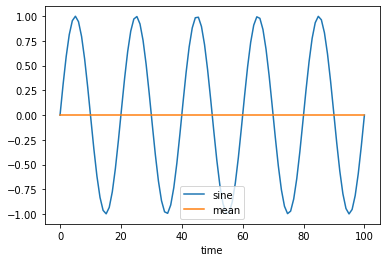

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

def sine_wave(freq, time, phase=0):
    omega = (2.0*np.pi)*freq
    phi = phase*(2.0*np.pi/360)
    return np.sin(omega*time - phi)

freq = 5
time = np.linspace(0,100,100)
sine = sine_wave(freq,time)
mean = np.array([np.mean(sine)] * len(sine))
data = pd.DataFrame({'time':time,
                     'sine':sine, 
                     'mean':mean})
data[['time','sine','mean']].plot(x='time')

Multiplying two of these sine waves together gives,
$$\sin(\omega_1 t - \phi_1) \sin(\omega_2 t - \phi_2)$$
There are two important cases to consider here:
1. $f_1 = f_2$. The frequencies are matched, so the product averages to a nonzero constant. 
2. $f_1 \neq f_2$. The frequencies are different, so the product averages to zero.

The figures below show the result of this for the first case where $f_1 = f_2 = 5$ (left), and for the second case where $f_1 = 5.0$ and $f_2 = 2.5$ (right). The phases are both zero.

<AxesSubplot:xlabel='time'>

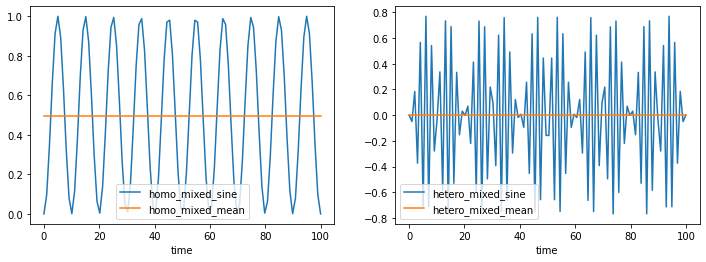

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12,4)

data['homo_mixed_sine'] = np.multiply(data.sine, data.sine)
data['homo_mixed_mean'] = np.mean(data.homo_mixed_sine)
data[['time','homo_mixed_sine','homo_mixed_mean']].plot(x='time', ax=axes[0])

f1 = 5.0
f2 = 2.5
data['hetero_mixed_sine'] = np.multiply(sine_wave(f1,data.time), sine_wave(f2,data.time))
data['hetero_mixed_mean'] = np.mean(data.hetero_mixed_sine)
data[['time','hetero_mixed_sine','hetero_mixed_mean']].plot(x='time', ax=axes[1])

It can be seen that the first case (left) does in fact yield a nonzero constant for the average, whereas, the second case (right) yields zero for the average. So the theory works.

You might be wondering if there is a way to determine the value of this "nonzero constant", and how it relates to the value of the signal you are trying the measure. For this we use the product-to-sum trigonometric identity for sines to get,
$$I_1\sin(\omega_1 t - \phi_1)\ I_2\sin(\omega_2 t - \phi_2) = \frac{I_1 I_2}{2}\left\{ \cos\left[(\omega_1-\omega_2) t - (\phi_1-\phi_2)\right] - \cos\left[(\omega_1+\omega_2) t - (\phi_1+\phi_2)\right] \right\}$$
When the frequencies are the same, $\omega = \omega_1 = \omega_2$, and the right-hand side of the equation above reduces to,
$$\frac{I_1 I_2}{2}\left\{ \cos\left(\phi_1-\phi_2\right) - \cos\left[2 \omega t - (\phi_1+\phi_2)\right] \right\}$$
When we take the average value of the expression above, the cosine term with the time-dependence vanishes since the cosine function also averages to zero. So then we are left with,
$$\frac{I_1 I_2}{2}\cos\left(\phi_1-\phi_2\right)$$
This gives the value of the constant at the output of the lock-in amplifier. It can be seen that this is proportional to half of the product of the intensities of the two signals. So for the example above, where the intensities are both 1, it makes sense that the constant value is $1/2$. The value of the modulated input signal will be related to either $I_1$ or $I_2$ depending on which one is taken to be the reference and input signal. 

Since there is a cosine term that depends on the phase difference, the lock-in amplifier has phase-sensitive detection. This means it's important that the reference signal and input signal not only share the same frequency, but are also in-phase with each other. It is thus necessary to allow for the reference signal to be phase-shifted such that the phase-matching condition can be satisfied.

## Making Some Noise
Adding noise to one of the sine waves which will act as the modulated input signal will allow us to test the capability of the lock-in amplifier to detect the signal even in a noisy environment. Below, I have added noise to the sine wave from before.

<AxesSubplot:xlabel='time'>

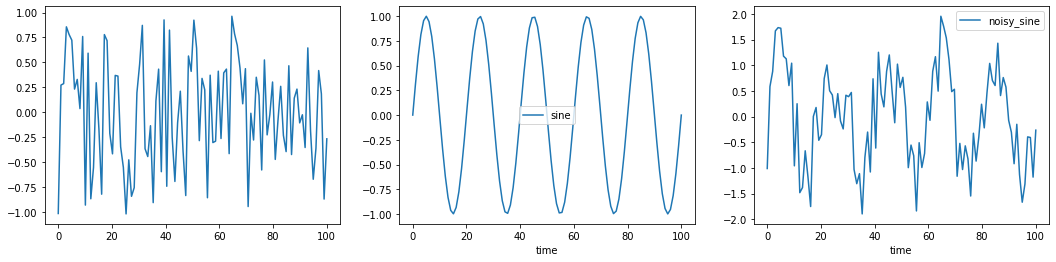

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18,4)

noise = np.array([(2 * np.random.random() - 1) for a in range(data.time.size)])
noise_mean = np.mean(noise)
noise -= noise_mean
axes[0].plot(data.time, noise)

data[['time','sine']].plot(x='time', ax=axes[1])

data['noisy_sine'] = noise + data.sine
data[['time','noisy_sine']].plot(x='time', ax=axes[2])

It can be seen that the sinusoidal behaviour is still noticeable in the plot on the right since the noise has an intensity which is comparible to the sine wave. The product of the noisy sine wave above and the pristine sine wave of the same frequency is plotted below on the left. Noise is also added to one of the sine waves with different frequencies on the right.

<AxesSubplot:xlabel='time'>

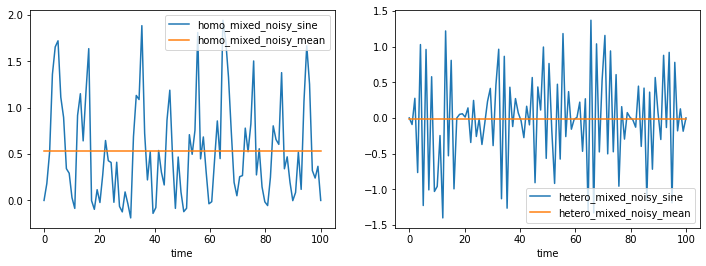

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12,4)

data['homo_mixed_noisy_sine'] = np.multiply(data.noisy_sine, data.sine)
data['homo_mixed_noisy_mean'] = np.mean(data.homo_mixed_noisy_sine)
data[['time','homo_mixed_noisy_sine','homo_mixed_noisy_mean']].plot(x='time', ax=axes[0])

data['hetero_mixed_noisy_sine'] = np.multiply(noise + sine_wave(f1,data.time), sine_wave(f2,data.time))
data['hetero_mixed_noisy_mean'] = np.mean(data.hetero_mixed_noisy_sine)
data[['time','hetero_mixed_noisy_sine','hetero_mixed_noisy_mean']].plot(x='time', ax=axes[1])

We can clearly see that the noise did not significantly change the results. However, the noise can degrade the accuracy of the of the measurement if it is intense enough. If the intensity of the noise was much larger, the sinusoidal behaviour would not be noticeable, as the sine wave would be hidden in the noise floor. I will demonstrate this now.

## Making More Noise
Lock-in amplifiers boast the ability to detect a signal even when it is swamped by noise. However, the noise does diminish the accuracy of the measurement. Here the previous procedure is repeated, but the intensity of the noise is increased to 10 times the intensity of the sine wave. This should effectively shroud the sine wave in noise. 

<AxesSubplot:xlabel='time'>

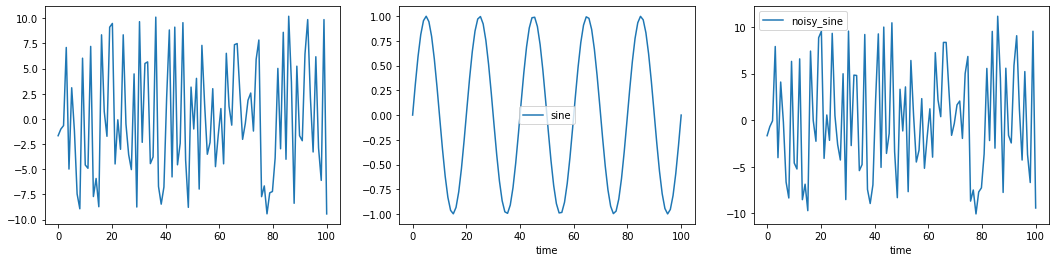

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18,4)

noise = np.array([10*(2 * np.random.random() - 1) for a in range(data.time.size)])
noise_mean = np.mean(noise)
noise -= noise_mean
axes[0].plot(data.time, noise)

data[['time','sine']].plot(x='time', ax=axes[1])

data['noisy_sine'] = noise + data.sine
data[['time','noisy_sine']].plot(x='time', ax=axes[2])

Above, the plots on the left and right show that the sine wave is effectively lost in the noise since adding the sine wave seems to make no difference in the appearance of the noise. The same averaging process as from before is repeated below. 

<AxesSubplot:xlabel='time'>

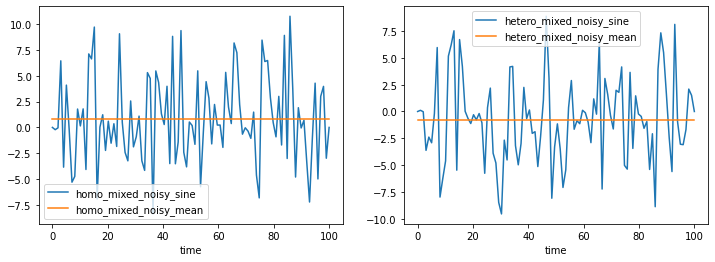

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12,4)

data['homo_mixed_noisy_sine'] = np.multiply(data.noisy_sine, data.sine)
data['homo_mixed_noisy_mean'] = np.mean(data.homo_mixed_noisy_sine)
data[['time','homo_mixed_noisy_sine','homo_mixed_noisy_mean']].plot(x='time', ax=axes[0])

data['hetero_mixed_noisy_sine'] = np.multiply(noise + sine_wave(f1,data.time), sine_wave(f2,data.time))
data['hetero_mixed_noisy_mean'] = np.mean(data.hetero_mixed_noisy_sine)
data[['time','hetero_mixed_noisy_sine','hetero_mixed_noisy_mean']].plot(x='time', ax=axes[1])

We can see that the noise has ruined the measurement, as the averaging of the waves with different frequencies no longer results in a zero, but instead has a nonzero value. Let's zoom in on this.

<AxesSubplot:xlabel='time'>

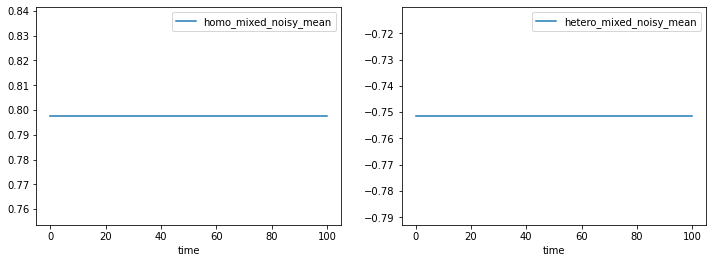

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12,4)
data[['time','homo_mixed_noisy_mean']].plot(x='time', ax=axes[0])
data[['time','hetero_mixed_noisy_mean']].plot(x='time', ax=axes[1])

Now it can be seen that not only did the noise intensity change the mean value for the product of the sine waves of different frequencies, but it also changed the mean value of the product of the sine wave with equal frequencies. This may occur because the noise partly mimics a signal with a certain freqency or effectively shifts the apparent phase of the signal. For this reason, it is possible to extract a signal form the noise, but the noise should be within reason. 